In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os


os.chdir("C:/Users/bahri/Desktop/Football_performance_analysis")

In [21]:
df=pd.read_excel("merged_players.xlsx")

In [42]:


# Position columns
position_cols = ["position_1", "position_2", "position_3"]

# Clean and normalize
for col in position_cols:
    df[col] = df[col].fillna("none").str.lower()

# Mapping from detailed positions to general roles
position_map = {
    "st": "striker", "cf": "striker", "lw": "striker", "rw": "striker",
    "cam": "midfielder", "cm": "midfielder", "cdm": "midfielder", "rm": "midfielder", "lm": "midfielder",
    "cb": "defender", "rb": "defender", "lb": "defender", "rwb": "defender", "lwb": "defender",
    "gk": "goalkeeper"
}

# Function to extract general roles from the 3 position columns
def extract_general_roles(row):
    roles = set()
    for col in position_cols:
        pos = row[col]
        if pos != "none":
            mapped = position_map.get(pos)
            if mapped:
                roles.add(mapped)
    return list(roles)

# Apply function
df["general_roles"] = df.apply(extract_general_roles, axis=1)

# One-hot encode general roles
for role in ["striker", "midfielder", "defender", "goalkeeper"]:
    df[role] = df["general_roles"].apply(lambda roles: int(role in roles))




In [44]:
# 2. Encode the 'age_group' column
df["young"] = df["age_group"].apply(lambda x: 1 if str(x).lower() == "young" else 0)



In [45]:
df.to_excel("merged_players.xlsx", index=False)
print("✅ File saved as encoded_positions.xlsx")

✅ File saved as encoded_positions.xlsx


C:\Users\bahri\AppData\Local\Temp\ipykernel_29736\4007227943.py:31: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


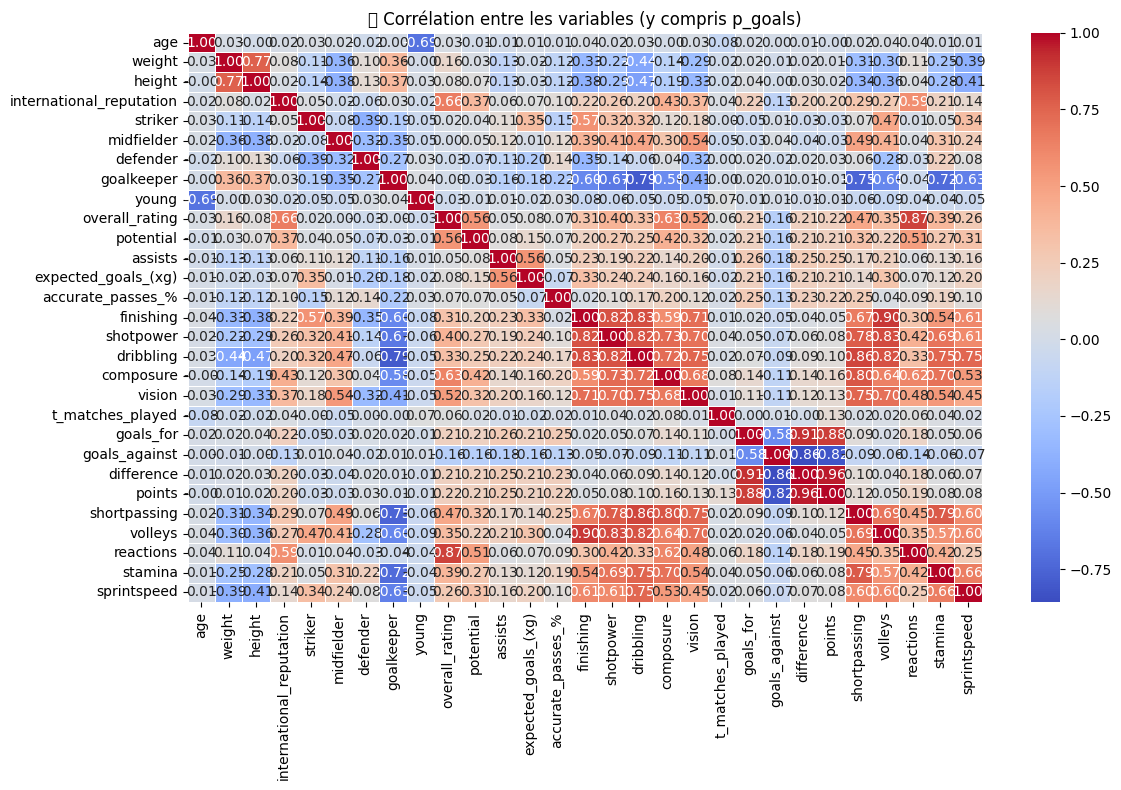

In [5]:
selected_cols = [
    # Profil joueur
    "age", "weight", "height", "international_reputation",
    "striker", "midfielder", "defender", "goalkeeper", "young",


    # Performance individuelle
    "overall_rating", "potential",
    "assists", "expected_goals_(xg)", "accurate_passes_%",
    "finishing", "shotpower", "dribbling", "composure", "vision",

    # Contexte collectif
    "t_matches_played", "goals_for", "goals_against", "difference", "points",

    # Capacités techniques supplémentaires
    "shortpassing", "volleys", "reactions", "stamina", "sprintspeed"


]

# Garder uniquement les colonnes pertinentes
df_corr = df[selected_cols]

# Calcul des corrélations
corr_matrix = df_corr.corr()

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("🔍 Corrélation entre les variables (y compris p_goals)")
plt.tight_layout()
plt.show()


In [6]:
features = [
    "expected_goals_(xg)", "assists", "finishing", "shotpower",
    "volleys", "dribbling", "overall_rating",
    "vision", "composure", "reactions",
    "striker", "midfielder", "defender"
]

target = "p_goals"

# Drop rows where target is missing
df = df.dropna(subset=[target])
df.fillna(0, inplace=True)

# ✅ Explicitly select features only (avoid including non-numeric columns)
X = df[features]
y = df[target]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [8]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.4f} goals")
print(f"RMSE : {rmse:.4f} goals")
print(f"R² : {r2:.4f}")


MAE : 0.7072 goals
RMSE : 1.1746 goals
R² : 0.8710


In [27]:
reduced_features = [
    "expected_goals_(xg)",
    "vision",
    "striker",
    "shotpower"
    
]


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Keep only reduced features
X_reduced = df[reduced_features]
y = df["p_goals"]

# Train model
model_reduced = XGBRegressor()
model_reduced.fit(X_reduced, y)

# Predictions and evaluation
y_pred = model_reduced.predict(X_reduced)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f} goals")
print(f"RMSE: {rmse:.4f} goals")
print(f"R²: {r2:.4f}")


MAE: 0.1410 goals
RMSE: 0.2221 goals
R²: 0.9960


error analysis : 

In [30]:
# Predict again with the reduced model
y_pred = model_reduced.predict(X_reduced)

# Create error dataframe
errors_df = df.copy()
errors_df["predicted_goals"] = y_pred
errors_df["error"] = abs(errors_df["p_goals"] - errors_df["predicted_goals"])

# Sort by highest error
errors_sorted = errors_df.sort_values(by="error", ascending=False)

# Show top 10 worst predictions
print(errors_sorted[["p_goals", "predicted_goals", "error"]].head(10))


      p_goals  predicted_goals     error
1401        0         1.159109  1.159109
1007        2         0.942698  1.057302
80          6         4.977876  1.022124
925         0         0.988199  0.988199
279         4         3.059593  0.940407
430         4         3.090003  0.909997
1381        3         2.103028  0.896972
623         2         1.117001  0.882999
350         3         2.131924  0.868076
1171        4         3.132810  0.867190


In [31]:
import joblib
import json
import os

# === Créer le dossier si besoin ===
os.makedirs("models", exist_ok=True)

# === 1. Sauvegarde du modèle ===
joblib.dump(model_reduced, "models/xgb_goals_model_reduced.pkl")

# === 2. Sauvegarde des features ===
reduced_features = [
    "expected_goals_(xg)",
    "vision",
    "striker",
    "shotpower"
]
with open("models/features_goals_reduced.json", "w") as f:
    json.dump(reduced_features, f)

print("✅ Modèle réduit et features sauvegardés.")


✅ Modèle réduit et features sauvegardés.


the model performs extremely well overall (errors mostly < 1 goal).

Misclassifications at 0 goals are a bit more critical — we may be slightly overpredicting for low scorers.

Outliers like high goal scorers may benefit from a deeper tree or more estimators.

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Model & Random Search
xgb = XGBRegressor()
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,         # Try 30 combinations
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_reduced, y)

# Best parameters
print("✅ Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [78]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train final model with best parameters
final_model = XGBRegressor(
    subsample=0.8,
    n_estimators=200,
    max_depth=2,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X_reduced, y)

# Predictions
y_pred_final = final_model.predict(X_reduced)

# Evaluation
mae = mean_absolute_error(y, y_pred_final)
rmse = np.sqrt(mean_squared_error(y, y_pred_final))
r2 = r2_score(y, y_pred_final)

print(f"MAE: {mae:.4f} goals")
print(f"RMSE: {rmse:.4f} goals")
print(f"R²: {r2:.4f}")


MAE: 0.6142 goals
RMSE: 0.9743 goals
R²: 0.9229


In [ ]:
import joblib
import json
import os

# === 1. Créer les dossiers si besoin ===
os.makedirs("models", exist_ok=True)

# === 2. Sauvegarder le modèle XGBoost ===
joblib.dump(final_model, "models/xgb_goals_model.pkl")

# === 3. Sauvegarder les features utilisées ===
features = list(X_reduced.columns)
with open("models/features_goals.json", "w") as f:
    json.dump(features, f)

print("✅ Modèle et features sauvegardés avec succès.")


Metric	Value	Interpretation

R²	0.9229	Explains 92.29% of the variance in goals

MAE	0.6142 goals	On average, you're off by ~0.6 goals per player

RMSE	0.9743 goals	Rare large errors, still <1 goal on average

In [72]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)


In [73]:
from xgboost import XGBRegressor

# Use best parameters
model = XGBRegressor(
    subsample=0.8,
    n_estimators=200,
    max_depth=2,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🧪 Test MAE: {mae:.4f} goals")
print(f"🧪 Test RMSE: {rmse:.4f} goals")
print(f"🧪 Test R²: {r2:.4f}")



🧪 Test MAE: 0.7193 goals
🧪 Test RMSE: 1.2051 goals
🧪 Test R²: 0.8642


this means that the model is generalizing well:

The test performance is close to training

There’s no major overfitting

Prediction errors remain within 1 goal, which is great for football analysis

Let's Compare XGBoost with Other Models

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "XGBoost (Tuned)": XGBRegressor(
        subsample=0.8, n_estimators=200, max_depth=2, learning_rate=0.1,
        colsample_bytree=0.8, random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))

# Show as table
import pandas as pd

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)
print(results_df)


               Model       MAE      RMSE        R²
0  Linear Regression  0.676585  1.092200  0.888437
1      Random Forest  0.676136  1.156725  0.874866
2  Gradient Boosting  0.693788  1.182785  0.869164
4    XGBoost (Tuned)  0.719338  1.205058  0.864190
3                KNN  0.971525  1.537817  0.778831


we are going to proceed with linear regression 

In [76]:
import joblib
import json
import pandas as pd

# Your trained model (e.g., linear regression)
from sklearn.linear_model import LinearRegression

# Assume your model is already trained on X_train, y_train
model = LinearRegression()
model.fit(X_train, y_train)

# ✅ Save the trained model
joblib.dump(model, "linear_goals_model.pkl")

# ✅ Save the feature list in the correct order
with open("features_goals.json", "w") as f:
    json.dump(list(X_train.columns), f)



